In [1]:
import sys, os
sys.path.append('/home/quizznor/projects/phd-thesis/bin')

import warnings
# warnings.filterwarnings('error')

from utils.binaries import *
from utils.plotting import *

09:57:21 [INFO] utils          -- ( +1820ms) -- import logging


09:57:21 [INFO] utils.binaries -- (  +406ms) -- import numpy as np
09:57:23 [INFO] utils.binaries -- ( +2036ms) -- import pandas as pd
09:57:23 [INFO] utils.binaries -- (   +24ms) -- import binaries.tools as binaries
09:57:24 [INFO] utils.plotting -- ( +1128ms) -- import matplotlib.pyplot as plt
09:57:25 [INFO] utils.plotting -- ( +1102ms) -- import seaborn as sns
09:57:25 [DBUG] utils.plotting -- (   +59ms) -- font size set to 4
09:57:25 [DBUG] utils.plotting -- (    +9ms) -- figure size set to [2.4, 1.2]
09:57:25 [DBUG] utils.plotting -- (    +6ms) -- plotting style set to `notebook`.
09:57:25 [INFO] utils.plotting -- (   +16ms) -- import plotting.tools as plot


In [2]:
def remove_outliers(array):

    mu, sigma = np.mean(array), np.std(array)
    return array[(np.abs(array - mu) / sigma <= 3) & (array > 0)]

In [3]:
import datetime

col_names = [
    "runid",
    "telescope",
    "stepsize_cm",
    "date",
    "source",
    "ledCurrent_mA",
    "forDB",
    "jobfile",
    "comment",
]

runlist_oct = pd.read_csv(
        '/home/quizznor/projects/xy-calibration/config/calib_runlists/calA_runs_2023-10.list', sep=";", names=col_names, skipinitialspace=True, comment="#"
    )

runlist_oct['starttime'] = [datetime.datetime.strptime(f"{row.date} {row.jobfile}", '%Y-%m-%d %H-%M') for _, row in runlist_oct.iterrows()]


runlist_nov = pd.read_csv(
        '/home/quizznor/projects/xy-calibration/config/calib_runlists/calA_runs_2023-11.list', sep=";", names=col_names, skipinitialspace=True, comment="#"
    )

runlist_nov['starttime'] = [datetime.datetime.strptime(f"{row.date} {row.jobfile}", '%Y-%m-%d %H-%M') for _, row in runlist_nov.iterrows()]

'Heat #1: Before' : 17776664.726027396,
'Heat #1: After' : 17544910.82191781,
'Heat #2: Before' : 26292025.977011494,
'Heat #2: After' : 25567121.788990825,
'Heat #2: After' : 25688431.19266055,
'Heat #3: Before' : 19518613.704545453,
'Heat #3: After' : 19690935.398633257,


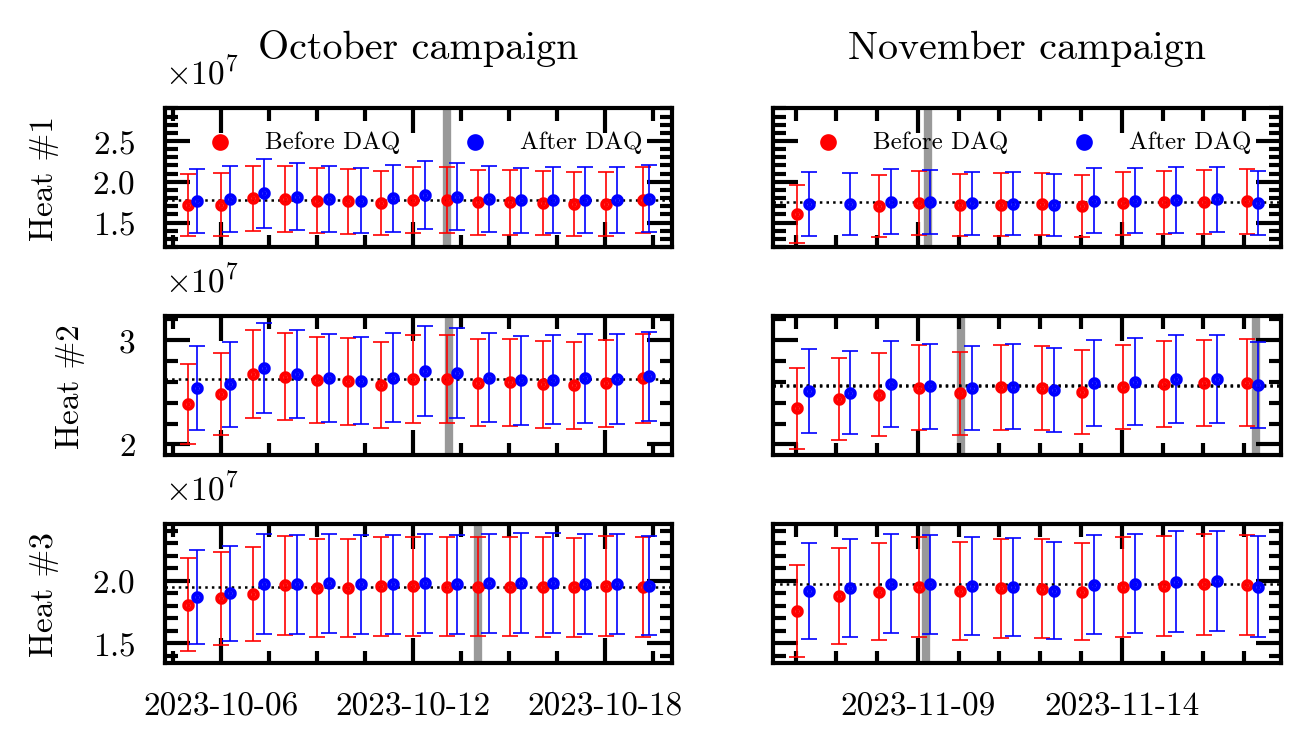

In [11]:
res_path = os.path.abspath('../results/')

fig, axes = plt.subplots(nrows=3, ncols=2, sharex='col', sharey='row')

warnings.filterwarnings('error')
warnings.simplefilter('ignore', DeprecationWarning)
measurements = [[], [], []]

for i, runlist in enumerate([runlist_oct, runlist_nov]):

    for _, row in runlist.iterrows():
        if 'm25' in row.runid: m = 0
        if 'm26' in row.runid: m = 1
        if 'm27' in row.runid: m = 2
        ax = axes[m, i]
        # ax.set_yscale('log')

        cal_file = res_path + f'/out_{row.runid}.txt'

        pixel, cal_xy, sum_adc, cal_std = np.loadtxt(cal_file, unpack=True, usecols=[0, 1, 2, 3])
        sum_adc = remove_outliers(sum_adc)
        x_data = [row.starttime for i in range(len(sum_adc))]

        is_before_daq = row.starttime.hour < 5 or row.starttime.hour > 22

        # ax.scatter(x_data, log_sum_adc, s=3, alpha=1, c='r' if is_before_daq else 'b', marker='.')
        ax.errorbar(row.starttime, np.mean(sum_adc), np.std(sum_adc), c='r' if is_before_daq else 'b', fmt='o', capsize=1, ms=0.5, elinewidth=0.2, capthick=0.2)
        measurements[m].append(np.mean(sum_adc))


axes[0, 0].set_title("October campaign")
axes[0, 1].set_title('November campaign')
axes[2, 0].xaxis.set_major_locator(plt.MaxNLocator(3))
axes[2, 1].xaxis.set_major_locator(plt.MaxNLocator(3))
axes[0, 0].scatter([], [], c='r', label='Before DAQ', s=1)
axes[0, 0].scatter([], [], c='b', label='After DAQ', s=1)
axes[0, 1].scatter([], [], c='r', label='Before DAQ', s=1)
axes[0, 1].scatter([], [], c='b', label='After DAQ', s=1)

axes[0, 0].legend(ncol=2, loc='upper center', fontsize=3)
axes[0, 1].legend(ncol=2, loc='upper center', fontsize=3)
axes[0, 0].set_ylim(1.2e7, 2.9e7)
# axes[1, 0].set_ylim(16, 18)
# axes[2, 0].set_ylim(15, 18)

# insert measurements
# extend = lambda x: x + datetime.timedelta(hours=2)

heat1_measurements = [datetime.datetime(2023, 10, 13, 1, 33), datetime.datetime(2023, 11, 9, 6, 12)]
heat2_measurements = [datetime.datetime(2023, 10, 13, 3, 9),  datetime.datetime(2023, 11, 10, 1, 23), datetime.datetime(2023, 11, 17, 7, 3)]
heat3_measurements = [datetime.datetime(2023, 10, 14, 1, 0),  datetime.datetime(2023, 11, 9, 4, 59)]

for i_m, m in enumerate(heat1_measurements):
    # axes[0][i_m].fill_between([m, extend(m)], y_max, color='k', alpha=0.4, zorder=0)
    axes[0][i_m].axvline(m, color='k', alpha=0.4, zorder=0)
    factor = measurements[0][16 if not i_m else 36]
    axes[0][i_m].axhline(factor, c='k', lw=0.3, ls=':')
    print(f"'Heat #1: {'Before' if not i_m else 'After'}' : {factor},")

for i_m, m in enumerate(heat2_measurements):
    # axes[1][int(not (not i_m))].fill_between([m, extend(m)], y_max, color='k', alpha=0.4, zorder=0)
    axes[1][int(not (not i_m))].axvline(m, color='k', alpha=0.4, zorder=0)
    factor = measurements[1][16 if i_m==0 else (37 if i_m==1 else -1)]
    axes[1][int(not (not i_m))].axhline(factor, c='k', lw=0.3, ls=':')
    print(f"'Heat #2: {'Before' if not i_m else 'After'}' : {factor},")


for i_m, m in enumerate(heat3_measurements):
    # axes[2][i_m].fill_between([m, extend(m)], y_max, color='k', alpha=0.4, zorder=0)
    axes[2][i_m].axvline(m, color='k', alpha=0.4, zorder=0)
    factor = measurements[2][18 if not i_m else 37]
    axes[2][i_m].axhline(factor, c='k', lw=0.3, ls=':')
    print(f"'Heat #3: {'Before' if not i_m else 'After'}' : {factor},")


axes[0, 0].set_ylabel("Heat #1")
axes[1, 0].set_ylabel("Heat #2")
axes[2, 0].set_ylabel("Heat #3")
plt.subplots_adjust(hspace=0.5)
#plt.savefig('calA.pdf', format='pdf')

# TRUE (NON-LOG) RESULTS! below

In [5]:
means = {
    'Heat #1: Before' : 17776664.726027396,
    'Heat #1: After' : 17544910.82191781,
    'Heat #2 1: Before' : 26292025.977011494,
    'Heat #2 2: Before' : 26292025.977011494,
    'Heat #2 1: After' : 25567121.788990825,
    'Heat #2 2: After' : 25688431.19266055,
    'Heat #3: Before' : 19518613.704545453,
    'Heat #3: After' : 19690935.398633257,
}

In [6]:
ratio = lambda x: (means[f"{x}: After"] - means[f"{x}: Before"]) / means[f"{x}: Before"] * 100

print(ratio("Heat #1"))
print(ratio("Heat #2 1"))
print(ratio("Heat #2 2"))
print(ratio("Heat #3"))


-1.3036973340126485
-2.7571256344204547
-2.2957332572191187
0.8828582638923452
